# Plant Disease Classification with Labeled Data

## Project Description

This project focuses on **plant disease classification** using the **PlantVillage dataset** from Kaggle.  
A deep learning model is trained on labeled leaf images to accurately identify different plant diseases.

### Include Libraries

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling,GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip "/content/drive/MyDrive/Plant_leaf_diseases/Plant_leaf_diseases_dataset.zip" -d "/content/Plant_leaf_diseases"

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: /content/Plant_leaf_diseases/Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (132).JPG  
  inflating: /content/Plant_leaf_diseases/Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1320).JPG  
  inflating: /content/Plant_leaf_diseases/Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1321).JPG  
  inflating: /content/Plant_leaf_diseases/Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1322).JPG  
  inflating: /content/Plant_leaf_diseases/Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1323).JPG  
  inflating: /content/Plant_leaf_diseases/Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1324).JPG  
  inflating: /content/Plant_leaf_diseases/Plant_leave_

### 1. Setting Parameters

In [6]:
import os
from pathlib import Path

# Klasör yolu
DATA_DIR = "Plant_leaf_diseases/Plant_leave_diseases_dataset_without_augmentation"
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2

# Path objesi oluştur
DATA_PATH_OBJECT = Path(DATA_DIR).resolve()

# Kontrol Bloğu
if not DATA_PATH_OBJECT.is_dir():
    # Hata durumunda yardımcı olmak için üst klasörün içine bakar
    print("\n--- HATA AYIKLAMA ---")
    parent_folder = "/content/Plant_leaf_diseases"

    if os.path.exists(parent_folder):
        print(f"'{parent_folder}' içindeki klasörler: {os.listdir(parent_folder)}")
    else:
        print(f"'/content/' içindeki klasörler: {os.listdir('/content/')}")

    # exit() yerine raise kullanıyoruz (Kernel restart hatasını önler)
    raise FileNotFoundError(f"HATA: '{DATA_PATH_OBJECT}' yolu bulunamadı. Lütfen yukarıdaki listeden doğru klasör adını kontrol et.")

else:
    print(f"BAŞARILI: Veri seti yolu doğrulandı -> {DATA_PATH_OBJECT}")

BAŞARILI: Veri seti yolu doğrulandı -> /content/Plant_leaf_diseases/Plant_leave_diseases_dataset_without_augmentation


### 2. Create Dataframe

In [7]:
filepaths = []
labels = []

# Browse through each class folder
for class_folder in DATA_PATH_OBJECT.iterdir():
    if class_folder.is_dir():
        class_name = class_folder.name

        # Collect images from class folder (Include *.JPG ve *.jpg)
        for image_path in class_folder.glob('*.[Jj][Pp][Gg]'):
            filepaths.append(str(image_path))
            labels.append(class_name)

df = pd.DataFrame({'filepath': filepaths, 'label': labels})

class_names = df['label'].unique().tolist()
NUM_CLASSES = len(class_names)
INPUT_SHAPE = IMG_SIZE + (3,)

print(f"All Folder: {len(df)}")
print(f"Percieved Class Number: {NUM_CLASSES}")

All Folder: 55446
Percieved Class Number: 39


### 3. Split the Datasets (Train and Validation)

In [8]:
# Split datasets with Stratify=True for distribution of classes
train_df, val_df = train_test_split(
    df,
    test_size=VALIDATION_SPLIT,
    shuffle=True,
    random_state=42,
    stratify=df['label']
)

### 4. Preprocessing and Loading with Data Generator

In [9]:
datagen = ImageDataGenerator(
    rescale=1./255,             # Normalizasyon
    rotation_range=20,          # Görüntüleri rastgele 20 dereceye kadar döndür
    width_shift_range=0.1,      # Görüntüleri yatayda %10 kaydır
    height_shift_range=0.1,     # Görüntüleri dikeyde %10 kaydır
    zoom_range=0.1,             # %10'a kadar rastgele yakınlaştırma yap
    horizontal_flip=True,       # Yatay çevirme yap
    fill_mode='nearest'         # Yeni pikselleri en yakın değerle doldur
)

# Loading training data
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

# Loading training data
val_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)


train_ds = train_generator
val_ds = val_generator

Found 44356 validated image filenames belonging to 39 classes.
Found 11090 validated image filenames belonging to 39 classes.


### 5. Create CNN Model

In [10]:
def create_basic_cnn_model(input_shape, num_classes):
    model = Sequential([
        # 1. Convolutional Layer
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),

        # 2. Convolutional Layer
        Conv2D(64, (3, 3), activation='relu',kernel_regularizer=l2(0.001)),
        MaxPooling2D((2, 2)),

        # 3. Convolutional Layer
        Conv2D(128, (3, 3), activation='relu',kernel_regularizer=l2(0.001)),
        MaxPooling2D((2, 2)),

        # Flatten
        Flatten(),

        # Fully Connected (Dense) Layers
        Dense(512, activation='relu'),
        Dropout(0.5),

        # Output Layer
        Dense(num_classes, activation='softmax')
    ])
    return model

model = create_basic_cnn_model(INPUT_SHAPE, NUM_CLASSES)

# Compiling
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n--- Model Özeti ---")
model.summary()

# --- 6. Training Model ---
EPOCHS = 10
print(f"\n--- Model Eğitimi Başlıyor ({EPOCHS} Epoch) ---")

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)



/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



--- Model Özeti ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 39)             │        20,007 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,958,823 (49.43 MB)

 Trainable params: 12,958,823 (49.43 MB)

 Non-trainable params: 0 (0.00 B)


--- Model Eğitimi Başlıyor (10 Epoch) ---


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 274s 193ms/step - accuracy: 0.4456 - loss: 2.0981 - val_accuracy: 0.7583 - val_loss: 0.8550
Epoch 2/10
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 262s 189ms/step - accuracy: 0.7374 - loss: 0.9053 - val_accuracy: 0.8189 - val_loss: 0.6253
Epoch 3/10
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 263s 190ms/step - accuracy: 0.8038 - loss: 0.6873 - val_accuracy: 0.8572 - val_loss: 0.5229
Epoch 4/10
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 265s 191ms/step - accuracy: 0.8283 - loss: 0.5990 - val_accuracy: 0.8800 - val_loss: 0.4585
Epoch 5/10
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 263s 190ms/step - accuracy: 0.8523 - loss: 0.5262 - val_accuracy: 0.8739 - val_loss: 0.4568
Epoch 6/10
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 263s 190ms/step - accuracy: 0.8629 - loss: 0.4981 - val_accuracy: 0.8874 - val_loss: 0.4012
Epoch 7/10
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 265s 191ms/step - accuracy: 0.8782 - loss: 0.4436 - val_accuracy: 0.9266 - val_loss: 0.2968
Epoch 8/10
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 263s 190ms/step - ac

### 6. Visualization of Output of CNN


--- HAFTA 1 SONUÇ GÖRSELLEŞTİRME ---
Toplam eğitilen epoch sayısı: 10


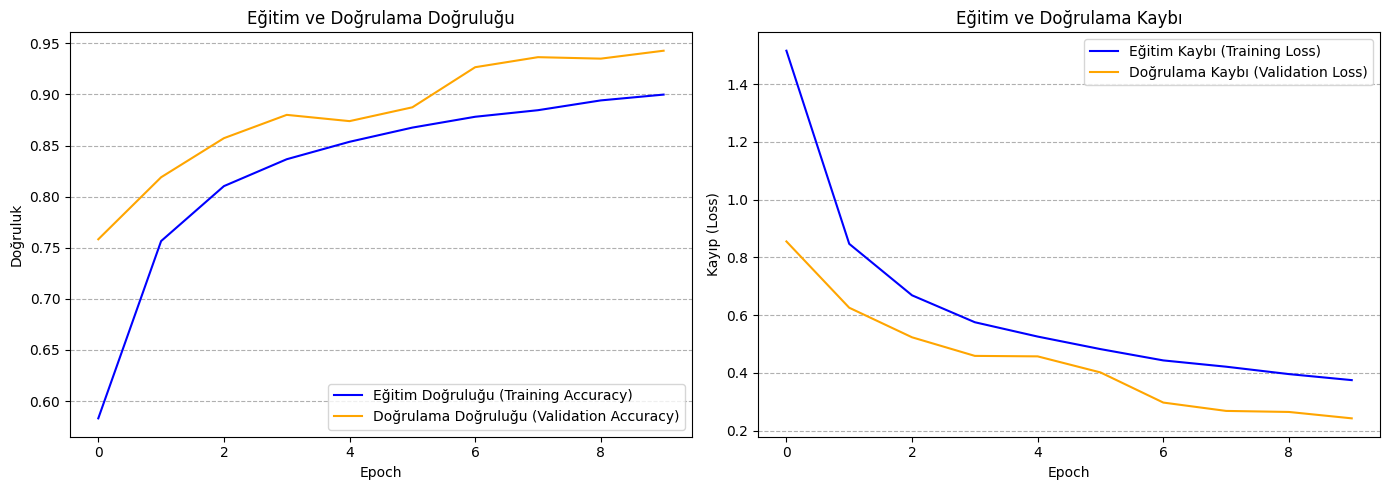

Eğitim Sonunda Elde Edilen Doğrulama Doğruluğu: 0.9427


In [ ]:
# --- 1. GEREKLİ VERİLERİ ÇEKME ---

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Eğitim yapılan toplam epoch sayısını belirleme
EPOCHS = len(acc)
epochs_range = range(EPOCHS)

print(f"\n--- HAFTA 1 SONUÇ GÖRSELLEŞTİRME ---")
print(f"Toplam eğitilen epoch sayısı: {EPOCHS}")

# --- 2. GRAFİKLERİ ÇİZME ---

plt.figure(figsize=(14, 5))

# 1. Doğruluk (Accuracy) Grafiği
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Eğitim Doğruluğu (Training Accuracy)', color='blue')
plt.plot(epochs_range, val_acc, label='Doğrulama Doğruluğu (Validation Accuracy)', color='orange')
plt.title('Eğitim ve Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--')

# 2. Kayıp (Loss) Grafiği
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Eğitim Kaybı (Training Loss)', color='blue')
plt.plot(epochs_range, val_loss, label='Doğrulama Kaybı (Validation Loss)', color='orange')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp (Loss)')
plt.legend(loc='upper right')
plt.grid(axis='y', linestyle='--')

plt.tight_layout() # Grafikler arasındaki boşluğu ayarlar
plt.show()

print(f"Eğitim Sonunda Elde Edilen Doğrulama Doğruluğu: {val_acc[-1]:.4f}")

### 7. Transfer Learning

In [13]:
# Early Stopping and Model Checkpoint Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', # Doğrulama kaybını izle
    patience=5,         # Kayıp 5 epoch boyunca iyileşmezse durdur
    restore_best_weights=True
)

# For saving the best model
checkpoint_filepath = 'best_transfer_model_checkpoint.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

### 8. Feature Extraction

In [14]:
base_model = MobileNetV2(
    input_shape=INPUT_SHAPE,
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

x=base_model.output
x= GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

transfer_model = Model(inputs=base_model.input, outputs=predictions)

transfer_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_fe = transfer_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stopping, model_checkpoint_callback]
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.7110 - loss: 1.0367

1387/1387 ━━━━━━━━━━━━━━━━━━━━ 307s 209ms/step - accuracy: 0.7111 - loss: 1.0364 - val_accuracy: 0.8967 - val_loss: 0.3139
Epoch 2/10
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.8617 - loss: 0.4246

1387/1387 ━━━━━━━━━━━━━━━━━━━━ 260s 188ms/step - accuracy: 0.8617 - loss: 0.4246 - val_accuracy: 0.9131 - val_loss: 0.2647
Epoch 3/10
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.8780 - loss: 0.3748

1387/1387 ━━━━━━━━━━━━━━━━━━━━ 259s 187ms/step - accuracy: 0.8780 - loss: 0.3748 - val_accuracy: 0.9210 - val_loss: 0.2442
Epoch 4/10
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 263s 189ms/step - accuracy: 0.8876 - loss: 0.3501 - val_accuracy: 0.9186 - val_loss: 0.2466
Epoch 5/10
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.8879 - loss: 0.3469

1387/1387 ━━━━━━━━━━━━━━━━━━━━ 263s 189ms/step - accuracy: 0.8879 - loss: 0.3469 - val_accuracy: 0.9217 - val_loss: 0.2363
Epoch 6/10
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 266s 192ms/step - accuracy: 0.8951 - loss: 0.3249 - val_accuracy: 0.9193 - val_loss: 0.2427
Epoch 7/10
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.8979 - loss: 0.3105

1387/1387 ━━━━━━━━━━━━━━━━━━━━ 262s 189ms/step - accuracy: 0.8979 - loss: 0.3105 - val_accuracy: 0.9323 - val_loss: 0.2084
Epoch 8/10
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 259s 187ms/step - accuracy: 0.8955 - loss: 0.3283 - val_accuracy: 0.9243 - val_loss: 0.2191
Epoch 9/10
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9042 - loss: 0.2977

1387/1387 ━━━━━━━━━━━━━━━━━━━━ 257s 185ms/step - accuracy: 0.9042 - loss: 0.2977 - val_accuracy: 0.9326 - val_loss: 0.2044
Epoch 10/10
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9036 - loss: 0.3012

1387/1387 ━━━━━━━━━━━━━━━━━━━━ 262s 189ms/step - accuracy: 0.9036 - loss: 0.3012 - val_accuracy: 0.9353 - val_loss: 0.1996


In [15]:
# En iyi ağırlıkları geri yükle (Feature Extraction sırasında en iyi performansı vereni)
transfer_model.load_weights(checkpoint_filepath)

# 1. Temel Modeli Tekrar Çözme
base_model.trainable = True

# 2. Çözülecek Katmanları Belirleme
# Modelin başındaki ilk 100 katmanı dondurmaya devam edelim (genel özellikleri koru).
for layer in base_model.layers[:100]:
    layer.trainable = False

# 3. Çok Düşük Öğrenme Oranı ile Yeniden Derleme
# ÖNEMLİ: Öğrenme oranını 100 kat düşürmek (1e-5) modelin bozulmasını engeller.
transfer_model.compile(
    optimizer=Adam(5e-6),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Eğitim geçmişini Fine-Tuning ile birleştirmek için epoch'ları ayarla
initial_epoch_ft = len(history_fe.history['accuracy'])
EPOCHS_FT = 10 # 10 epoch daha ince ayar yapalım
TOTAL_EPOCHS = initial_epoch_ft + EPOCHS_FT

print("\n--- İnce Ayar (Fine-Tuning) Eğitimi Başlıyor ---")
history_ft = transfer_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=TOTAL_EPOCHS,
    initial_epoch=initial_epoch_ft,
    callbacks=[early_stopping, model_checkpoint_callback]
)

# Final modeli kaydetme
transfer_model.save('final_best_transfer_model.h5')


--- İnce Ayar (Fine-Tuning) Eğitimi Başlıyor ---
Epoch 11/20
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 303s 203ms/step - accuracy: 0.4318 - loss: 9.5250 - val_accuracy: 0.8454 - val_loss: 1.0645
Epoch 12/20
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 264s 190ms/step - accuracy: 0.7882 - loss: 1.1524 - val_accuracy: 0.8976 - val_loss: 0.4405
Epoch 13/20
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 263s 190ms/step - accuracy: 0.8429 - loss: 0.6895 - val_accuracy: 0.9142 - val_loss: 0.3037
Epoch 14/20
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 263s 190ms/step - accuracy: 0.8618 - loss: 0.5191 - val_accuracy: 0.9222 - val_loss: 0.2637
Epoch 15/20
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 264s 191ms/step - accuracy: 0.8756 - loss: 0.4417 - val_accuracy: 0.9331 - val_loss: 0.2242
Epoch 16/20
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.8958 - loss: 0.3619

1387/1387 ━━━━━━━━━━━━━━━━━━━━ 266s 192ms/step - accuracy: 0.8958 - loss: 0.3619 - val_accuracy: 0.9365 - val_loss: 0.2032
Epoch 17/20
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9026 - loss: 0.3269

1387/1387 ━━━━━━━━━━━━━━━━━━━━ 267s 193ms/step - accuracy: 0.9026 - loss: 0.3269 - val_accuracy: 0.9436 - val_loss: 0.1732
Epoch 18/20
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9082 - loss: 0.3050

1387/1387 ━━━━━━━━━━━━━━━━━━━━ 267s 193ms/step - accuracy: 0.9082 - loss: 0.3050 - val_accuracy: 0.9457 - val_loss: 0.1623
Epoch 19/20
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9177 - loss: 0.2711

1387/1387 ━━━━━━━━━━━━━━━━━━━━ 269s 194ms/step - accuracy: 0.9177 - loss: 0.2711 - val_accuracy: 0.9491 - val_loss: 0.1614
Epoch 20/20
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9205 - loss: 0.2530

1387/1387 ━━━━━━━━━━━━━━━━━━━━ 266s 192ms/step - accuracy: 0.9205 - loss: 0.2530 - val_accuracy: 0.9537 - val_loss: 0.1460


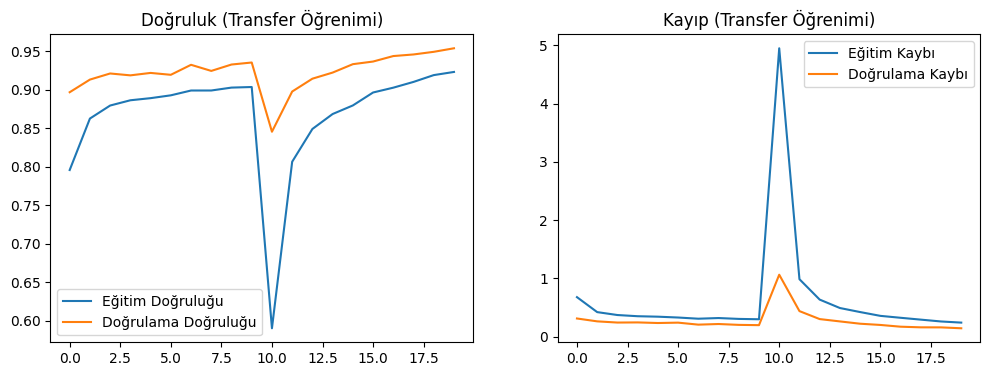

Transfer Öğrenimi Son Doğrulama Doğruluğu: 0.9537


In [17]:
# İki eğitimin sonuçlarını birleştirme
acc = history_fe.history['accuracy'] + history_ft.history['accuracy']
val_acc = history_fe.history['val_accuracy'] + history_ft.history['val_accuracy']
loss = history_fe.history['loss'] + history_ft.history['loss']
val_loss = history_fe.history['val_loss'] + history_ft.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Eğitim Doğruluğu')
plt.plot(epochs_range, val_acc, label='Doğrulama Doğruluğu')
plt.title('Doğruluk (Transfer Öğrenimi)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Eğitim Kaybı')
plt.plot(epochs_range, val_loss, label='Doğrulama Kaybı')
plt.title('Kayıp (Transfer Öğrenimi)')
plt.legend()
plt.show()

print(f"Transfer Öğrenimi Son Doğrulama Doğruluğu: {val_acc[-1]:.4f}")